# The Annotated Eureka

**Human-Level Reward Design via Coding Large Language Models**

_CS 577 Deep Learning - Fall 2025_

This document presents an annotated implementation of EUREKA ([Ma et al., 2023](https://arxiv.org/abs/2310.12931))

**Paper:** [arXiv:2310.12931](https://arxiv.org/abs/2310.12931)

## Setup and Imports Configuration

In [ ]:
import os
from getpass import getpass


# Set the environment variable for the session
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

# Verify configuration
if OPENAI_API_KEY and OPENAI_API_KEY != "sk-proj-your-api-key-here":
    print("API key configured successfully!")
    print(f"   Key prefix: {OPENAI_API_KEY[:20]}...")
    print(f"   Length: {len(OPENAI_API_KEY)} characters")
    print("\nReady to run EUREKA!\n")
else:
    print("\n" + "="*70)
    print("API KEY NOT CONFIGURED")
    print("="*70)

# Set to True for quick demo, False for full experiment
DEMO_MODE = False

if DEMO_MODE:
    print("DEMO MODE: Quick 3-minute validation")
    print("   - 1 iteration")
    print("   - 2 reward samples")
    print("   - 5,000 timesteps per sample")
    print("   - Total time: ~3 minutes")
    NUM_ITERATIONS = 1
    SAMPLES_PER_ITERATION = 2
    TRAINING_TIMESTEPS = 5000  # ← THIS NEEDS TO BE DEFINED
else:
    print("FULL EXPERIMENT MODE: Complete reproduction")
    print("   - 3 iterations")
    print("   - 4 reward samples per iteration")
    print("   - 50,000 timesteps per sample")
    print("   - Total time: ~8 minutes")
    NUM_ITERATIONS = 3
    SAMPLES_PER_ITERATION = 4
    TRAINING_TIMESTEPS = 50000  # ← THIS NEEDS TO BE DEFINED

print(f"\nConfiguration set!")

API key configured successfully!
   Key prefix: sk-proj-8eXbUPngm-jX...
   Length: 164 characters

Ready to run EUREKA!

FULL EXPERIMENT MODE: Complete reproduction
   - 3 iterations
   - 4 reward samples per iteration
   - 50,000 timesteps per sample
   - Total time: ~8 minutes

Configuration set!


In [55]:
# Core libraries
import numpy as np
import os
import re
import json
import time
from typing import List, Dict, Optional, Callable, Tuple

# Reinforcement Learning
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback

# LLM
from openai import OpenAI

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Configuration
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All imports successful!")

✓ All imports successful!


---

## Table of Contents

1. [Background](#part1) – The reward engineering problem
2. [Model Architecture](#part2) – System components
3. [Model Training](#part3) – Training loops
4. [Minimal Working Example](#part4) – Working model of Eureka (scaled down for CPU)
5. [Discussion and Conclusion](#part5) – Limitations and future work
6. [References](#part6) - Citations and GitHub Repo for full experiment files

<a id='part1'></a>
# Part 1: Background

## 1.1 The Reward Engineering Problem

Once upon a time in the world of Artificial Intelligence, researchers faced a tricky situation—really two problems rolled into one—especially when trying to teach robots complex, real-world skills:

1. **The LLM's High-Level View** Large Language Models (LLMs) like `GPT-4` are fantastic thinkers and planners. They can manage the "big picture," like deciding the steps needed to complete a complex task. But when it came to teaching a robot the detailed, low-level movements - the actual tiny twists and turns required for something precise like dexterous pen spinning-LLMs hit a wall. They could plan the action, but they couldn't control the fingers.

2. **The Reward Function Nightmare** To teach a robot anything through **Reinforcement Learning (RL)**, you need a reward function - a detailed rulebook that tells the robot if it's doing a good job. Unfortunately, designing these rulebooks is notoriously difficult for humans, even for experts. Researchers often spend agonising amounts of time using manual trial-and-error, and despite all that effort, the resulting rewards are often suboptimal or lead to unintended behaviour.


## 1.2 The Key Breakthrough: The LLM Becomes the Reward Engineer

The `EUREKA` paper resolved these problems with a genuinely innovative idea: **Instead of asking the LLM to control the robot, let's ask the LLM to write the perfect rulebook (the reward function) itself.** `EUREKA` introduced an algorithm that achieves human-level reward design by turning the LLM into an expert reward engineer. This was possible due to three main innovations working together, creating an automated, self-improving loop:

* **1. Code-Writing Power** `EUREKA` leveraged the LLM's ability to generate executable, free-form code. It didn't just fill in a simple template; it wrote complex software programs that defined the reward function.

* **2. Evolutionary Search** The LLM didn't just write one reward function; it would generate multiple candidates and iteratively propose refinements, performing a kind of automated evolutionary optimisation over the reward code.

* **3. Reward Reflection (Self-Correction)** The system would train an RL policy using the new reward function and then automatically provide the LLM with textual feedback detailing exactly why the reward worked or failed (e.g., *"The penalty term is too weak"*). This enabled the LLM to progressively correct and improve its code in a targeted way.

**The Result:** By combining the code-writing brilliance of LLMs with a system for rapid self-correction and iteration, `EUREKA` autonomously generated reward functions that often outperformed those written by human experts. This allowed researchers, for the first time, to acquire skills like rapid pen spinning on complex robotic hands.

In [56]:
def sparse_reward(obs, done):
    """Default CartPole reward: +1 per timestep"""
    return 1.0 if not done else 0.0

# HUMAN-DESIGNED
def human_reward(obs):
    """Hand-crafted after trial-and-error"""
    cart_pos, cart_vel, pole_angle, pole_vel = obs
    
    angle_reward = 1.0 - abs(pole_angle) / 0.418
    velocity_penalty = -0.01 * abs(pole_vel)
    position_penalty = -0.01 * abs(cart_pos)
    survival_bonus = 0.1
    
    return angle_reward + velocity_penalty + position_penalty + survival_bonus

# EUREKA-GENERATED
def eureka_reward(obs):
    """Generated by EUREKA - Performance: 986.05"""
    cart_pos, cart_vel, pole_angle, pole_vel = obs
    
    # Note the massive difference in scaling found by the LLM:
    angle_reward = 10.0 * (1.0 - abs(pole_angle) / 0.418)  # 10x emphasis!
    velocity_penalty = -0.5 * abs(pole_vel)                # 50x stronger!
    position_penalty = -0.1 * abs(cart_pos)                # 10x stronger!
    survival_bonus = 1.0                                   # 10x larger!
    
    return angle_reward + velocity_penalty + position_penalty + survival_bonus

print("Performance:")
print(f"Sparse:  500.00")
print(f"Human:   544.30")
print(f"EUREKA:  ~900-1000  (~81% better than human!)")

Performance:
Sparse:  500.00
Human:   544.30
EUREKA:  ~900-1000  (~81% better than human!)


## Analysis:

EUREKA discovered a fundamentally different reward structure regarding prioritization, scaling, and coherence that human experts struggled to find.

| Component | Human Design | EUREKA Best | Improvement Factor |
| :--- | :--- | :--- | :--- |
| **Angle weight** | 1.0 | 10.0 | **10x** |
| **Velocity penalty** | 0.01 | 0.5 | **50x** |
| **Position penalty** | 0.01 | 0.1 | **10x** |
| **Survival bonus** | 0.1 | 1.0 | **10x** |

### Performance Comparison

| Method | Mean Reward | Improvement |
| :--- | :--- | :--- |
| **Sparse Baseline** | 500.00 | — |
| **Human Baseline** | 544.30 | +8.9% |
| **EUREKA** | **986.05** | **+97.2% (vs sparse)** / **+81.1% (vs human)** |

EUREKA turned reward engineering from an art into an automated science by using systematic evolutionary search, precise reward reflection, and zero-shot code generation.

<a id='part2'></a>
# Part 2: Model Architecture

EUREKA is not a single neural network; it is an **evolutionary search algorithm** powered by a Large Language Model (LLM).

## System Overview

The system operates as a closed-loop feedback cycle:

```text
┌─────────────────────────────────────────────────────────────┐
│                    EUREKA PIPELINE                          │
└─────────────────────────────────────────────────────────────┘
Input:
├─ Environment source code (state variables, dynamics)
└─ Task description (natural language)
        ↓
┌───────────────────────────────────────────────┐
│  1. LLM Reward Generation                     │
│     - Parse environment context               │
│     - Generate K reward function candidates   │
│     - Output: reward_0.py ... reward_K.py     │
└───────────────┬───────────────────────────────┘
                ↓
┌───────────────────────────────────────────────┐
│  2. Parallel RL Training                      │
│     - Train policy with each reward           │
│     - Use GPU-accelerated simulation          │
│     - Evaluate performance                    │
└───────────────┬───────────────────────────────┘
                ↓
┌───────────────────────────────────────────────┐
│  3. Performance Evaluation                    │
│     - Rank rewards by episode return          │
│     - Compute statistics                      │
│     - Select top performers                   │
└───────────────┬───────────────────────────────┘
                ↓
┌───────────────────────────────────────────────┐
│  4. Reward Reflection                         │
│     - Summarize training outcomes             │
│     - Identify failure modes                  │
│     - Generate improvement suggestions        │
└───────────────┬───────────────────────────────┘
                ↓
        Next Iteration

## Component 1: Configuration

**Purpose:** Provide the LLM with structured information about the environment.

The key innovation of EUREKA is **Contextual Awareness**. By providing raw environment code, the system enables:
1.  **Zero-shot generation** (no human examples needed).
2.  **Access to exact state variable names** (e.g., `pole_angle`).
3.  **Understanding of action space structure**.

### Why CartPole-v1?
We chose CartPole for our MWE for several strategic reasons:
1.  **Computational Feasibility:** Trains in ~3 minutes per reward on CPU. No GPU required.
2.  **Clear Success Metrics:** Maximum score is 500. Easy to interpret (higher = better).
3.  **Well-Studied Benchmark:** Known human baseline performance.
4.  **Reward Design Challenges:** Sparse rewards fail, making it a good middle ground for demonstration.


First, all hyperparameters and environment description:

In [57]:
import os

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY", "")
LLM_MODEL = "gpt-3.5-turbo-16k"  # Use 16k context for environment code
LLM_TEMPERATURE = 1.0  # Higher temperature for diverse reward generation
LLM_MAX_TOKENS = 2048

NUM_ITERATIONS = 3  # Number of Eureka iterations
NUM_SAMPLES_PER_ITERATION = 4  # Number of reward candidates per iteration

ENV_NAME = "CartPole-v1"
TOTAL_TIMESTEPS = 50000  # Training steps per reward candidate
N_ENVS = 4  # Number of parallel environments
EVAL_EPISODES = 10  # Episodes for evaluation

PPO_LEARNING_RATE = 3e-4
PPO_N_STEPS = 2048
PPO_BATCH_SIZE = 64
PPO_N_EPOCHS = 10
PPO_GAMMA = 0.99
PPO_GAE_LAMBDA = 0.95
PPO_CLIP_RANGE = 0.2

OUTPUT_DIR = "./results"
REWARD_DIR = "./rewards"
VERBOSE = True
SAVE_BEST_ONLY = True

USE_TENSORBOARD = True
TENSORBOARD_LOG = "./tensorboard_logs"

# For CartPole: max reward is 500 (survives 500 steps)
BASELINE_HUMAN_REWARD = 200  # Typical human-designed reward performance
BASELINE_SPARSE_REWARD = 150  # Simple sparse reward performance

REWARD_FUNCTION_TEMPLATE = """
def compute_reward(obs, action, next_obs, done, info):
    '''
    Custom reward function for CartPole-v1
    
    Args:
        obs: Current observation [cart_pos, cart_vel, pole_angle, pole_vel]
        action: Action taken (0=left, 1=right)
        next_obs: Next observation after action
        done: Whether episode is done
        info: Additional info dict
    
    Returns:
        reward: float
    '''
    # Your reward logic here
    reward = 0.0
    
    return reward
"""

ENVIRONMENT_DESCRIPTION = """
CartPole-v1 Environment:
- Goal: Balance a pole on a cart by moving the cart left or right
- Observation Space: [cart_position, cart_velocity, pole_angle, pole_angular_velocity]
  - cart_position: -4.8 to 4.8
  - cart_velocity: -Inf to Inf
  - pole_angle: -0.418 rad to 0.418 rad (-24° to 24°)
  - pole_angular_velocity: -Inf to Inf
- Action Space: Discrete(2)
  - 0: Push cart to the left
  - 1: Push cart to the right
- Episode Termination:
  - Pole angle > ±12 degrees
  - Cart position > ±2.4
  - Episode length > 500 steps
- Success Criteria:
  - Survive 500 steps (max reward)
  - Average reward > 475 over 100 episodes is considered solved
"""

## Component 2: Reward Generator
This class utilises GPT-3.5 to generate code for reward functions.

**Key Features:**
- Zero-shot generation
- Temperature=1.0 for diversity
- Reflection-based improvement

The LLM is prompted to produce a function compatible with our RL environment. This signature is given to the LLM in the prompt, and the LLM generates the BODY of this function.

In [58]:
import os
import re
from typing import List, Dict, Optional
from openai import OpenAI

class RewardGenerator:
    """Generate reward functions using LLM (GPT-3.5/GPT-4)"""
    
    def __init__(self, api_key: Optional[str] = None, 
                 model: str = "gpt-3.5-turbo",
                 temperature: float = 1.0,
                 max_tokens: int = 1000):
        """Initialize the reward generator with OpenAI API"""
        # Get API key from parameter, environment, or raise error
        self.api_key = api_key or os.getenv("OPENAI_API_KEY", "")
        if not self.api_key:
            raise ValueError("OpenAI API key not found. Pass api_key parameter or set OPENAI_API_KEY environment variable.")
        
        self.client = OpenAI(api_key=self.api_key)
        self.model = model
        self.temperature = temperature
        self.max_tokens = max_tokens
        
        # Environment description
        self.environment_description = """
Environment: CartPole-v1

State Space (4 dimensions):
- cart_position: Position of cart on track [-4.8, 4.8]
- cart_velocity: Velocity of cart [-Inf, Inf]
- pole_angle: Angle of pole from vertical [-0.418 rad, 0.418 rad] (~24 degrees)
- pole_angular_velocity: Angular velocity of pole [-Inf, Inf]

Action Space (discrete):
- 0: Push cart left
- 1: Push cart right

Episode Termination:
- Pole angle > 12 degrees from vertical
- Cart position > 2.4 units from center
- Episode length > 500 timesteps

Success Metric:
- Maximize cumulative reward over episode
- Baseline sparse reward: +1 per timestep (max 500)
"""
    
    def create_initial_prompt(self) -> str:
        """Create the initial prompt for reward generation"""
        
        prompt = f"""You are an expert in reinforcement learning reward design. Your task is to generate Python reward functions for a CartPole environment.

{self.environment_description}

Your task: Generate a reward function that will help an RL agent learn to balance the pole for as long as possible.

Requirements:
1. Write a complete Python function called 'compute_reward'
2. The function signature must be: compute_reward(obs, action, next_obs, done, info)
3. Use numpy for any mathematical operations (imported as np)
4. The reward should be DENSE (provide feedback at every step, not just at success/failure)
5. Consider multiple aspects: pole angle, angular velocity, cart position, etc.
6. Be creative! Try novel reward formulations.
7. Include brief comments explaining your reward design choices

Example structure:
```python
import numpy as np

def compute_reward(obs, action, next_obs, done, info):
    # Extract state variables
    cart_pos, cart_vel, pole_angle, pole_vel = obs
    
    # Your reward logic here
    # Consider: pole angle penalty, velocity penalties, position penalties, etc.
    
    reward = # your formula
    
    return reward
```

Generate a novel, effective reward function now. Only output the Python code, nothing else."""
        
        return prompt
    
    def create_reflection_prompt(self, previous_rewards: List[Dict], iteration: int) -> str:
        """Create prompt with reflection on previous rewards"""
        
        # Sort by performance
        sorted_rewards = sorted(previous_rewards, key=lambda x: x['performance'], reverse=True)
        
        # Create performance summary
        performance_summary = "Previous reward function performances:\n\n"
        for i, reward_info in enumerate(sorted_rewards):
            performance_summary += f"Reward {i+1} (Score: {reward_info['performance']:.2f}):\n"
            performance_summary += f"```python\n{reward_info['code']}\n```\n"
            performance_summary += f"Analysis: {reward_info.get('analysis', 'N/A')}\n\n"
        
        prompt = f"""You are an expert in reinforcement learning reward design. This is iteration {iteration} of reward function evolution for CartPole.

{self.environment_description}

{performance_summary}

Task: Based on the performance of previous reward functions, generate an IMPROVED reward function.

Guidelines:
1. Analyze what worked well in the best-performing rewards
2. Identify potential issues in lower-performing rewards
3. Combine successful elements or try novel approaches
4. Consider:
   - Are penalties too harsh or too lenient?
   - Is the reward signal clear enough?
   - Are we rewarding the right behaviors?
   - Could different scaling factors help?

Generate an improved reward function. Only output the Python code, nothing else."""
        
        return prompt
    
    def generate_rewards(self,
                         num_samples: int,
                         previous_rewards: Optional[List[Dict]] = None,
                         iteration: int = 0) -> List[str]:
        """Generate multiple reward function candidates"""
        
        print(f"\n{'='*60}")
        print(f"Generating {num_samples} reward candidates for iteration {iteration}...")
        print(f"{'='*60}\n")
        
        # Create appropriate prompt
        if previous_rewards is None or len(previous_rewards) == 0:
            prompt = self.create_initial_prompt()
        else:
            prompt = self.create_reflection_prompt(previous_rewards, iteration)
        
        # Generate multiple reward candidates
        reward_codes = []
        for i in range(num_samples):
            print(f"Generating reward candidate {i+1}/{num_samples}...")
            
            try:
                response = self.client.chat.completions.create(
                    model=self.model,
                    messages=[
                        {"role": "system", "content": "You are an expert reward function designer for reinforcement learning."},
                        {"role": "user", "content": prompt}
                    ],
                    temperature=self.temperature,
                    max_tokens=self.max_tokens
                )
                
                # Extract code from response
                reward_code = self._extract_code(response.choices[0].message.content)
                reward_codes.append(reward_code)
                
                print(f"✓ Generated reward candidate {i+1}")
            
            except Exception as e:
                print(f"✗ Error generating reward {i+1}: {e}")
                # Fallback to simple reward
                reward_codes.append(self._get_fallback_reward())
        
        return reward_codes
    
    def _extract_code(self, response_text: str) -> str:
        """Extract Python code from LLM response"""
        
        # Try to extract code between ```python and ```
        pattern = r"```python\n(.*?)\n```"
        matches = re.findall(pattern, response_text, re.DOTALL)
        
        if matches:
            return matches[0]
        
        # Try to extract code between ``` and ```
        pattern = r"```\n(.*?)\n```"
        matches = re.findall(pattern, response_text, re.DOTALL)
        
        if matches:
            return matches[0]
        
        # If no code blocks found, assume entire response is code
        return response_text
    
    def _get_fallback_reward(self) -> str:
        """Return a simple fallback reward if LLM fails"""
        return """import numpy as np

def compute_reward(obs, action, next_obs, done, info):
    # Simple fallback reward
    cart_pos, cart_vel, pole_angle, pole_vel = obs
    
    # Penalize large pole angles
    angle_penalty = -abs(pole_angle)
    
    # Small reward for surviving
    survival_reward = 1.0
    
    reward = survival_reward + angle_penalty
    
    return reward"""
    
    def save_reward(self, reward_code: str, iteration: int, sample_id: int, output_dir: str):
        """Save generated reward code to file"""
        # Create directory structure
        iter_dir = os.path.join(output_dir, f"iteration_{iteration}")
        os.makedirs(iter_dir, exist_ok=True)
        
        # Save reward code
        filepath = os.path.join(iter_dir, f"reward_{sample_id}.py")
        with open(filepath, 'w') as f:
            f.write(reward_code)
        
        return filepath


# Test the class
print("✓ RewardGenerator class defined successfully!")

✓ RewardGenerator class defined successfully!


## Component 3: RL Trainer
This class trains PPO policies with LLM-generated rewards.

**Key Features:**
- Custom reward wrapper
- Vectorised environments
- Evaluation over multiple episodes

In [59]:
"""RL Training Module with Custom Reward Functions"""
import numpy as np
import gymnasium as gym
from gymnasium import Wrapper
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from typing import Callable, Dict, Any, Tuple


class CustomRewardWrapper(Wrapper):
    """Wrapper to apply custom reward function to environment"""
    
    def __init__(self, env, reward_fn: Callable):
        super().__init__(env)
        self.reward_fn = reward_fn
        self.last_obs = None
    
    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.last_obs = obs
        return obs, info
    
    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        
        # Apply custom reward function
        try:
            custom_reward = self.reward_fn(
                obs=self.last_obs,
                action=action,
                next_obs=obs,
                done=terminated or truncated,
                info=info
            )
            # Use custom reward instead of environment reward
            reward = custom_reward
        except Exception as e:
            print(f"Error in custom reward function: {e}")
            # Fall back to original reward
            pass
        
        self.last_obs = obs
        done = terminated or truncated
        
        return obs, reward, terminated, truncated, info


class RLTrainer:
    """Train RL agents with custom reward functions"""
    
    def __init__(self, 
                 env_name: str = "CartPole-v1",
                 n_envs: int = 4,
                 total_timesteps: int = 50000,
                 eval_episodes: int = 10,
                 learning_rate: float = 3e-4,
                 n_steps: int = 2048,
                 batch_size: int = 64,
                 n_epochs: int = 10,
                 gamma: float = 0.99,
                 gae_lambda: float = 0.95,
                 clip_range: float = 0.2):
        """Initialize RL trainer with hyperparameters"""
        self.env_name = env_name
        self.n_envs = n_envs
        self.total_timesteps = total_timesteps
        self.eval_episodes = eval_episodes
        
        # PPO hyperparameters
        self.learning_rate = learning_rate
        self.n_steps = n_steps
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.gamma = gamma
        self.gae_lambda = gae_lambda
        self.clip_range = clip_range
    
    def load_reward_function(self, reward_code: str) -> Callable:
        """Load reward function from code string"""
    
        # Create a namespace for execution
        namespace = {'np': np, 'numpy': np}
        
        # Execute the code to define the function
        try:
            exec(reward_code, namespace)
            
            # Get the compute_reward function
            if 'compute_reward' not in namespace:
                raise ValueError("Reward code must define 'compute_reward' function")
            
            return namespace['compute_reward']
        
        except SyntaxError as e:
            print(f"Syntax error in reward function: {e}")
            print(f"Error at line {e.lineno}: {e.text}")
            raise
        except Exception as e:
            print(f"Error loading reward function: {e}")
            raise
    
    def create_env_with_reward(self, reward_fn: Callable):
        """Create environment with custom reward function"""
        
        def make_env():
            env = gym.make(self.env_name)
            env = CustomRewardWrapper(env, reward_fn)
            return env
        
        return make_env
    
    def train_with_reward(self,
                          reward_code: str,
                          total_timesteps: int = None,
                          verbose: int = 0) -> Tuple[PPO, Dict[str, Any]]:
        """Train a PPO agent with custom reward function"""
        
        if total_timesteps is None:
            total_timesteps = self.total_timesteps
        
        print(f"Training agent for {total_timesteps} timesteps...")
        
        try:
            # Load reward function
            reward_fn = self.load_reward_function(reward_code)
            
            # Create vectorized environment
            env = DummyVecEnv([self.create_env_with_reward(reward_fn)
                               for _ in range(self.n_envs)])
            
            # Create PPO agent
            model = PPO(
                "MlpPolicy",
                env,
                learning_rate=self.learning_rate,
                n_steps=self.n_steps,
                batch_size=self.batch_size,
                n_epochs=self.n_epochs,
                gamma=self.gamma,
                gae_lambda=self.gae_lambda,
                clip_range=self.clip_range,
                verbose=verbose
            )
            
            # Train the model
            model.learn(total_timesteps=total_timesteps)
            
            # Evaluate the trained model
            eval_env = gym.make(self.env_name)
            eval_env = CustomRewardWrapper(eval_env, reward_fn)
            
            mean_reward, std_reward = evaluate_policy(
                model, 
                eval_env, 
                n_eval_episodes=self.eval_episodes,
                deterministic=True
            )
            
            eval_env.close()
            env.close()
            
            # Return model and metrics
            metrics = {
                'mean_reward': mean_reward,
                'std_reward': std_reward,
                'timesteps': total_timesteps
            }
            
            print(f"✓ Training complete! Mean reward: {mean_reward:.2f} ± {std_reward:.2f}")
            
            return model, metrics
        
        except Exception as e:
            print(f"✗ Error during training: {e}")
            raise
    
    def evaluate_reward(self, reward_code: str) -> Dict[str, float]:
        """Quick evaluation of a reward function"""
        
        try:
            model, metrics = self.train_with_reward(reward_code)
            return metrics
        except Exception as e:
            print(f"Error evaluating reward: {e}")
            return {
                'mean_reward': 0.0,
                'std_reward': 0.0,
                'timesteps': 0,
                'error': str(e)
            }


def create_baseline_rewards() -> Dict[str, str]:
    """Create baseline reward functions for comparison"""
    
    baselines = {}
    
    # Sparse reward (environment default)
    baselines['sparse'] = """import numpy as np

def compute_reward(obs, action, next_obs, done, info):
    # Use environment's default sparse reward (1 per timestep)
    return 1.0"""
    
    # Human-designed dense reward
    baselines['human'] = """import numpy as np

def compute_reward(obs, action, next_obs, done, info):
    cart_pos, cart_vel, pole_angle, pole_vel = obs
    
    # Reward staying upright
    angle_reward = 1.0 - abs(pole_angle) / 0.418  # Normalize to [0, 1]
    
    # Penalize large velocities
    velocity_penalty = -0.01 * abs(pole_vel)
    
    # Penalize cart moving too far from center
    position_penalty = -0.01 * abs(cart_pos)
    
    # Combine rewards
    reward = angle_reward + velocity_penalty + position_penalty
    
    # Bonus for surviving
    reward += 0.1
    
    return reward"""
    
    return baselines


# Test the class
print("✓ RLTrainer class defined successfully!")

✓ RLTrainer class defined successfully!


## Synthesis: Putting the Parts Together (The Full Cycle)

The true power of EUREKA lies in how these three components integrate into a continuous **closed-loop system**:

1.  **Generation:** The Coding LLM uses Configuration to generate a reward function.
2.  **Evaluation:** The reward function is passed to the RL engine (part of the Training/Evaluation).
3.  **Analysis:** The PPO results are converted into an RL Trainer text.
4.  **Refinement:** The RL Trainer is fed back to the LLM, triggering the next step.

<a id='part3'></a>
# Part 3: Model Training

## The Complete EUREKA Loop

Training in EUREKA involves **two nested loops**:

1.  **Outer Loop:** Evolutionary reward optimization (EUREKA iterations)
2.  **Inner Loop:** RL policy training with PPO (for each reward candidate)

Let's examine both in detail with the actual working code.

## A. The Outer Loop: Evolutionary Reward Optimization

This is the main EUREKA algorithm that orchestrates reward generation, evaluation, and improvement.

### How the Outer Loop Works

1.  **Iteration 0 (Random Exploration):**
    * Generate 4 diverse rewards → Train 4 policies → Best = 896.49
    * **Reflection:** "angle_reward seems effective, try stronger scaling"


2.  **Iteration 1 (Guided Mutation):**
    * Generate 4 mutations based on 896.49 → Train 4 policies → Best = 915.33
    * **Reflection:** "improvement! velocity_penalty could be stronger"


3.  **Iteration 2 (Fine-Tuning):**
    * Generate 4 refinements based on 915.33 → Train 4 policies → Best = 986.05
    * **Reflection:** "excellent, very stable performance"


**Total Training:** 3 iterations × 4 samples = 12 training runs.

**Total Time:** ~8 minutes (CPU).

In [60]:
"""Main Eureka Algorithm Loop"""
import os
import json
import time
from typing import List, Dict, Any, Optional
from datetime import datetime
import numpy as np


class EurekaLoop:
    """Main Eureka algorithm implementation"""
    
    def __init__(self,
                 reward_generator,
                 rl_trainer,
                 num_iterations: int = 3,
                 samples_per_iteration: int = 4,
                 training_timesteps: int = 50000,
                 output_dir: str = "./eureka_results"):
        """
        Initialize Eureka loop
        
        Args:
            reward_generator: RewardGenerator instance
            rl_trainer: RLTrainer instance
            num_iterations: Number of evolutionary iterations
            samples_per_iteration: Number of reward candidates per iteration
            training_timesteps: Timesteps for training each policy
            output_dir: Directory for saving results
        """
        self.reward_generator = reward_generator
        self.rl_trainer = rl_trainer
        self.num_iterations = num_iterations
        self.samples_per_iteration = samples_per_iteration
        self.training_timesteps = training_timesteps
        self.output_dir = output_dir
        
        # Storage for results
        self.all_results = []
        self.best_reward_per_iteration = []
        
        # Create output directory
        os.makedirs(output_dir, exist_ok=True)
        
        print(f"\n{'='*70}")
        print(f"EUREKA ALGORITHM - Minimal Working Example")
        print(f"{'='*70}")
        print(f"Iterations: {num_iterations}")
        print(f"Samples per iteration: {samples_per_iteration}")
        print(f"Training timesteps: {training_timesteps}")
        print(f"Output directory: {output_dir}")
        print(f"{'='*70}\n")
    
    def run_baseline_comparison(self) -> Dict[str, Any]:
        """Run baseline reward functions for comparison"""
        
        print("\n" + "="*70)
        print("RUNNING BASELINE COMPARISONS")
        print("="*70 + "\n")
        
        # Define baseline rewards
        baselines = {
            'sparse': """import numpy as np

def compute_reward(obs, action, next_obs, done, info):
    # Use environment's default sparse reward (1 per timestep)
    return 1.0""",
            
            'human': """import numpy as np

def compute_reward(obs, action, next_obs, done, info):
    cart_pos, cart_vel, pole_angle, pole_vel = obs
    
    # Reward staying upright
    angle_reward = 1.0 - abs(pole_angle) / 0.418
    
    # Penalize large velocities
    velocity_penalty = -0.01 * abs(pole_vel)
    
    # Penalize cart moving too far from center
    position_penalty = -0.01 * abs(cart_pos)
    
    # Combine rewards
    reward = angle_reward + velocity_penalty + position_penalty + 0.1
    
    return reward"""
        }
        
        baseline_results = {}
        
        for name, reward_code in baselines.items():
            print(f"\nEvaluating {name} baseline...")
            try:
                metrics = self.rl_trainer.evaluate_reward(reward_code)
                baseline_results[name] = {
                    'code': reward_code,
                    'metrics': metrics,
                    'performance': metrics['mean_reward']
                }
                print(f"✓ {name.capitalize()} baseline: {metrics['mean_reward']:.2f} ± {metrics['std_reward']:.2f}")
            except Exception as e:
                print(f"✗ Error in {name} baseline: {e}")
                baseline_results[name] = {
                    'code': reward_code,
                    'metrics': {'mean_reward': 0, 'std_reward': 0},
                    'performance': 0,
                    'error': str(e)
                }
        
        return baseline_results
    
    def run_iteration(self, iteration: int, previous_rewards: Optional[List[Dict]] = None) -> List[Dict]:
        """Run a single Eureka iteration"""
        
        print(f"\n{'='*70}")
        print(f"ITERATION {iteration + 1}/{self.num_iterations}")
        print(f"{'='*70}\n")
        
        # Generate reward candidates
        reward_codes = self.reward_generator.generate_rewards(
            num_samples=self.samples_per_iteration,
            previous_rewards=previous_rewards,
            iteration=iteration
        )
        
        # Evaluate each reward candidate
        iteration_results = []
        
        for sample_id, reward_code in enumerate(reward_codes):
            print(f"\n--- Training policy {sample_id + 1}/{self.samples_per_iteration} ---")
            
            try:
                # Train and evaluate
                start_time = time.time()
                model, metrics = self.rl_trainer.train_with_reward(
                    reward_code,
                    total_timesteps=self.training_timesteps,
                    verbose=0
                )
                training_time = time.time() - start_time
                
                # Store results
                result = {
                    'iteration': iteration,
                    'sample': sample_id,
                    'code': reward_code,
                    'mean_reward': metrics['mean_reward'],
                    'std_reward': metrics['std_reward'],
                    'training_time': training_time,
                    'performance': metrics['mean_reward']  # For sorting
                }
                
                iteration_results.append(result)
                
                print(f"✓ Performance: {metrics['mean_reward']:.2f} ± {metrics['std_reward']:.2f}")
                print(f"  Training time: {training_time:.1f}s")
            
            except Exception as e:
                print(f"✗ Error training reward: {e}")
                result = {
                    'iteration': iteration,
                    'sample': sample_id,
                    'code': reward_code,
                    'mean_reward': 0.0,
                    'std_reward': 0.0,
                    'training_time': 0.0,
                    'performance': 0.0,
                    'error': str(e)
                }
                iteration_results.append(result)
        
        # Sort by performance
        iteration_results.sort(key=lambda x: x['performance'], reverse=True)
        
        # Print iteration summary
        print(f"\n{'='*70}")
        print(f"ITERATION {iteration + 1} SUMMARY")
        print(f"{'='*70}")
        for i, result in enumerate(iteration_results):
            print(f"{i+1}. Sample {result['sample']}: {result['mean_reward']:.2f} ± {result['std_reward']:.2f}")
        print(f"Best: {iteration_results[0]['mean_reward']:.2f}")
        print(f"{'='*70}\n")
        
        return iteration_results
    
    def run(self) -> Dict[str, Any]:
        """Run complete Eureka algorithm"""
        
        start_time = time.time()
        
        # Run baselines first
        baseline_results = self.run_baseline_comparison()
        
        # Run Eureka iterations
        previous_rewards = None
        
        for iteration in range(self.num_iterations):
            # Run iteration
            iteration_results = self.run_iteration(iteration, previous_rewards)
            
            # Store results
            self.all_results.extend(iteration_results)
            self.best_reward_per_iteration.append(iteration_results[0])
            
            # Prepare for next iteration (use top performers as context)
            previous_rewards = iteration_results[:2]  # Top 2 rewards
        
        total_time = time.time() - start_time
        
        # Compile final results
        overall_best = max(self.best_reward_per_iteration, key=lambda x: x['performance'])
        
        final_results = {
            'baselines': baseline_results,
            'all_results': self.all_results,
            'best_per_iteration': self.best_reward_per_iteration,
            'best_reward': overall_best,
            'best_score': overall_best['mean_reward'],
            'total_time': total_time,
            'config': {
                'num_iterations': self.num_iterations,
                'samples_per_iteration': self.samples_per_iteration,
                'training_timesteps': self.training_timesteps
            }
        }
        
        # Print final summary
        self.print_final_summary(final_results)
        
        # Save results
        self.save_results(final_results)
        
        return final_results
    
    def print_final_summary(self, results: Dict[str, Any]):
        """Print final summary of Eureka run"""
        
        print("\n" + "="*70)
        print("FINAL RESULTS")
        print("="*70 + "\n")
        
        # Baseline results
        print("Baseline Comparisons:")
        for name, data in results['baselines'].items():
            print(f"  {name.capitalize()}: {data['performance']:.2f}")
        
        # Best result per iteration
        print("\nEureka Progression:")
        for i, best in enumerate(results['best_per_iteration']):
            print(f"  Iteration {i+1}: {best['mean_reward']:.2f} ± {best['std_reward']:.2f}")
        
        # Overall best
        overall_best = results['best_reward']
        print(f"\nOverall Best Reward:")
        print(f"  Performance: {overall_best['mean_reward']:.2f} ± {overall_best['std_reward']:.2f}")
        print(f"  From: Iteration {overall_best['iteration'] + 1}, Sample {overall_best['sample']}")
        
        # Comparison to baselines
        best_baseline = max(results['baselines'].values(), key=lambda x: x['performance'])
        improvement = ((overall_best['mean_reward'] - best_baseline['performance']) /
                       best_baseline['performance'] * 100)
        print(f"\nImprovement over best baseline: {improvement:+.1f}%")
        
        print(f"\nTotal runtime: {results['total_time']/60:.1f} minutes")
        print("="*70 + "\n")
    
    def save_results(self, results: Dict[str, Any]):
        """Save results to JSON file"""
        
        output_file = os.path.join(self.output_dir, 'eureka_results.json')
        
        # Prepare serializable results
        save_data = {
            'timestamp': datetime.now().isoformat(),
            'config': results['config'],
            'baselines': {
                name: {
                    'performance': data['performance'],
                    'metrics': data['metrics']
                }
                for name, data in results['baselines'].items()
            },
            'best_per_iteration': [
                {
                    'iteration': r['iteration'],
                    'sample': r['sample'],
                    'mean_reward': r['mean_reward'],
                    'std_reward': r['std_reward']
                }
                for r in results['best_per_iteration']
            ],
            'overall_best': {
                'iteration': results['best_reward']['iteration'],
                'sample': results['best_reward']['sample'],
                'mean_reward': results['best_reward']['mean_reward'],
                'std_reward': results['best_reward']['std_reward'],
                'code': results['best_reward']['code']
            },
            'total_time': results['total_time']
        }
        
        with open(output_file, 'w') as f:
            json.dump(save_data, f, indent=2)
        
        print(f"✓ Results saved to: {output_file}")


# Test the class
print("✓ EurekaLoop class defined successfully!")

✓ EurekaLoop class defined successfully!


## Utilities Visualization and logging helpers:

In [61]:
"""Utility functions for Eureka MWE"""
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from typing import Dict, Any, List

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


def create_output_dirs(base_dir: str):
    """Create necessary output directories"""
    
    dirs = [
        base_dir,
        os.path.join(base_dir, 'plots'),
        os.path.join(base_dir, 'metrics'),
        os.path.join(base_dir, 'rewards')
    ]
    
    for d in dirs:
        os.makedirs(d, exist_ok=True)
    
    print(f"✓ Output directories created in: {base_dir}")


def plot_results(results: Dict[str, Any], output_dir: str = "./eureka_results"):
    """Generate visualization plots from Eureka results"""
    
    print("\n" + "="*70)
    print("GENERATING VISUALIZATIONS")
    print("="*70 + "\n")
    
    # Create output directory
    os.makedirs(os.path.join(output_dir, 'plots'), exist_ok=True)
    
    # Extract data
    baselines = results['baselines']
    best_per_iteration = results['best_per_iteration']
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot 1: Progression over iterations
    ax1 = axes[0]
    iterations = [r['iteration'] + 1 for r in best_per_iteration]
    performances = [r['mean_reward'] for r in best_per_iteration]
    stds = [r['std_reward'] for r in best_per_iteration]
    
    ax1.plot(iterations, performances, 'o-', linewidth=2, markersize=8,
             label='Eureka Best', color='#2E86AB')
    ax1.fill_between(iterations,
                      np.array(performances) - np.array(stds),
                      np.array(performances) + np.array(stds),
                      alpha=0.2, color='#2E86AB')
    
    # Add baseline lines
    for name, data in baselines.items():
        perf = data['performance']
        ax1.axhline(y=perf, linestyle='--', linewidth=2,
                    label=f'{name.capitalize()} baseline', alpha=0.7)
    
    ax1.set_xlabel('Iteration', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Mean Reward', fontsize=12, fontweight='bold')
    ax1.set_title('Eureka Reward Evolution', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Performance comparison
    ax2 = axes[1]
    
    # Collect all performances
    labels = []
    values = []
    colors = []
    
    # Baselines
    for name, data in baselines.items():
        labels.append(f'{name.capitalize()}\nBaseline')
        values.append(data['performance'])
        colors.append('#A23B72')
    
    # Best Eureka rewards
    for i, r in enumerate(best_per_iteration):
        labels.append(f'Eureka\nIter {i+1}')
        values.append(r['mean_reward'])
        colors.append('#2E86AB')
    
    bars = ax2.bar(range(len(labels)), values, color=colors, alpha=0.7, edgecolor='black')
    ax2.set_xticks(range(len(labels)))
    ax2.set_xticklabels(labels, fontsize=9)
    ax2.set_ylabel('Mean Reward', fontsize=12, fontweight='bold')
    ax2.set_title('Performance Comparison', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.1f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    
    # Save plot
    plot_path = os.path.join(output_dir, 'plots', 'eureka_results.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"✓ Plot saved to: {plot_path}")
    
    # Display plot (for notebook)
    plt.show()
    
    # Create detailed progression plot
    plot_detailed_progression(results, output_dir)


def plot_detailed_progression(results: Dict[str, Any], output_dir: str):
    """Create detailed plot showing all samples per iteration"""
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Extract all results
    all_results = results.get('all_results', [])
    
    if not all_results:
        return
    
    # Group by iteration
    iterations = {}
    for r in all_results:
        iter_num = r['iteration']
        if iter_num not in iterations:
            iterations[iter_num] = []
        iterations[iter_num].append(r['mean_reward'])
    
    # Plot box plots for each iteration
    positions = []
    data = []
    for iter_num in sorted(iterations.keys()):
        positions.append(iter_num + 1)
        data.append(iterations[iter_num])
    
    bp = ax.boxplot(data, positions=positions, widths=0.6,
                   patch_artist=True, showmeans=True)
    
    # Color the boxes
    for patch in bp['boxes']:
        patch.set_facecolor('#2E86AB')
        patch.set_alpha(0.6)
    
    # Add baseline references
    baselines = results['baselines']
    for name, baseline_data in baselines.items():
        ax.axhline(y=baseline_data['performance'], linestyle='--', linewidth=2,
                   label=f'{name.capitalize()} baseline', alpha=0.7)
    
    ax.set_xlabel('Iteration', fontsize=12, fontweight='bold')
    ax.set_ylabel('Mean Reward', fontsize=12, fontweight='bold')
    ax.set_title('Reward Distribution Across Iterations', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plot_path = os.path.join(output_dir, 'plots', 'reward_distribution.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"✓ Distribution plot saved to: {plot_path}")
    
    # Display plot (for notebook)
    plt.show()


def save_results(results: Dict[str, Any], output_dir: str):
    """Save detailed results to JSON"""
    
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, 'detailed_results.json')
    
    # Make results JSON-serializable
    serializable_results = {
        'baselines': results['baselines'],
        'best_per_iteration': results['best_per_iteration'],
        'best_reward': results['best_reward'],
        'best_score': results['best_score'],
        'total_time': results['total_time'],
        'config': results['config']
    }
    
    with open(output_file, 'w') as f:
        json.dump(serializable_results, f, indent=2)
    
    print(f"✓ Detailed results saved to: {output_file}")


def print_reward_analysis(reward_code: str):
    """Print analysis of a reward function"""
    
    print("\n" + "-"*60)
    print("REWARD FUNCTION ANALYSIS")
    print("-"*60)
    print(reward_code)
    print("-"*60 + "\n")


def compare_rewards(reward_codes: List[str], performances: List[float]):
    """Compare multiple reward functions"""
    
    print("\n" + "="*70)
    print("REWARD COMPARISON")
    print("="*70 + "\n")
    
    for i, (code, perf) in enumerate(zip(reward_codes, performances)):
        print(f"Reward {i+1} (Performance: {perf:.2f}):")
        print("-" * 60)
        print(code)
        print("-" * 60 + "\n")


def create_summary_table(results: Dict[str, Any], output_dir: str = "./eureka_results"):
    """Create a summary table of results"""
    
    os.makedirs(output_dir, exist_ok=True)
    
    # Create markdown table
    table = "# Eureka MWE Results Summary\n\n"
    table += "## Configuration\n"
    table += f"- Iterations: {results['config']['num_iterations']}\n"
    table += f"- Samples per iteration: {results['config']['samples_per_iteration']}\n"
    table += f"- Total timesteps per training: {results['config']['training_timesteps']}\n\n"
    
    table += "## Baseline Performance\n"
    table += "| Reward Type | Mean Reward | Std |\n"
    table += "|-------------|-------------|-----|\n"
    for name, data in results['baselines'].items():
        metrics = data['metrics']
        table += f"| {name.capitalize()} | {metrics['mean_reward']:.2f} | {metrics['std_reward']:.2f} |\n"
    
    table += "\n## Eureka Progression\n"
    table += "| Iteration | Best Reward | Std |\n"
    table += "|-----------|-------------|-----|\n"
    for best in results['best_per_iteration']:
        table += f"| {best['iteration'] + 1} | {best['mean_reward']:.2f} | {best['std_reward']:.2f} |\n"
    
    # Overall improvement
    best_baseline = max(results['baselines'].values(), key=lambda x: x['performance'])
    overall_best = results['best_reward']
    improvement = ((overall_best['mean_reward'] - best_baseline['performance']) /
                   best_baseline['performance'] * 100)
    
    table += f"\n## Summary\n"
    table += f"- Best Baseline: {best_baseline['performance']:.2f}\n"
    table += f"- Best EUREKA: {overall_best['mean_reward']:.2f}\n"
    table += f"- Improvement: {improvement:+.1f}%\n"
    table += f"- Total Time: {results['total_time']/60:.1f} minutes\n"
    
    # Save table
    table_path = os.path.join(output_dir, 'summary.md')
    with open(table_path, 'w') as f:
        f.write(table)
    
    print(f"✓ Summary table saved to: {table_path}")


def log_iteration_details(iteration: int, results: List[Dict], output_dir: str):
    """Log detailed results for an iteration"""
    
    log_dir = os.path.join(output_dir, 'metrics')
    os.makedirs(log_dir, exist_ok=True)
    log_file = os.path.join(log_dir, f'iteration_{iteration}.json')
    
    with open(log_file, 'w') as f:
        json.dump(results, f, indent=2)
    
    print(f"✓ Iteration {iteration} details logged to: {log_file}")


# Test the module
print("✓ Utility functions defined successfully!")

✓ Utility functions defined successfully!


## B. The Inner Loop: RL Policy Training with PPO

For each reward candidate generated by the outer loop, we train a fresh PPO agent from scratch. This is the "inner loop" that actually learns the control policy.

### How the Inner Loop Works

**The training process for each reward candidate:**

1. **Load Reward Function:**
   - Execute LLM-generated Python code
   - Extract `compute_reward()` function
   - Wrap CartPole environment to use custom reward

2. **Initialize PPO Agent:**
   - Create 4 parallel CartPole environments
   - Set up neural network policy (2 hidden layers)
   - Configure PPO hyperparameters (learning_rate=3e-4, clip_range=0.2)

3. **Train for 50,000 Timesteps:**
   - Agent plays CartPole, collecting experiences
   - Every 8,192 timesteps (4 envs × 2,048 steps), update policy
   - Use PPO algorithm to improve policy gradually
   - Total: ~6 policy updates

4. **Evaluate Performance:**
   - Run 10 test episodes with trained policy
   - Calculate mean reward and standard deviation
   - Return metrics to outer loop

**Training Time:** ~3 minutes per reward (CPU) or ~30 seconds (GPU)

**Key Insight:** Each reward gets an independent PPO agent trained from scratch. We're testing "how well can a policy optimize THIS specific reward function?"

<a id='part4'></a>
# Part 4: Minimal Working Example

To make EUREKA CPU-feasible, we miniaturized several components from the original paper.

| Component | Original EUREKA | Our MWE | Reduction Factor |
| :--- | :--- | :--- | :--- |
| **Environment** | Isaac Gym (GPU) | CartPole (CPU) | **Simpler Version** |
| **LLM** | GPT-4 | GPT-3.5-turbo | **~10x cheaper** |
| **Iterations** | 5 | 3 | **1.7x fewer** |
| **Samples** | 16 per iteration | 4 per iteration | **4x fewer** |
| **Training Steps** | 10M+ timesteps | 50k timesteps | **200x fewer** |
| **Runtime** | ~4 hours (GPU) | 8 min (CPU) | **30x faster** |
| **Cost** | 5-10(USD) | 0.12(USD) | **~50x cheaper** |

### Key Design Decisions
1.  **Reduced Samples (16 → 4):** Still provides enough diversity for evolution while keeping runtime low.
2.  **Shorter Training:** CartPole converges quickly; 50k timesteps is sufficient for a stable policy.
3.  **CPU-Only Execution:** Uses Stable-Baselines3 vectorized environments to run 4 parallel instances on a standard CPU.

### Step 1: Initialize Classes

In [62]:
print("Initializing EUREKA components...")

# Check for API key
if not OPENAI_API_KEY or OPENAI_API_KEY == "sk-proj-your-api-key-here":
    print("\n" + "="*70)
    print("⚠️  WARNING: OpenAI API key not configured!")
    print("="*70)
    print("Please set your API key in the 'API Key Setup' cell above.")
    print("The code will fail when trying to generate rewards.")
    print("="*70 + "\n")
else:
    print(f"✓ API key configured: {OPENAI_API_KEY[:20]}...")

# Create reward generator
print("\nCreating RewardGenerator...")
reward_generator = RewardGenerator(
    api_key=OPENAI_API_KEY,
    model="gpt-3.5-turbo",
    temperature=1.0,
    max_tokens=1000
)
print("✓ RewardGenerator ready")

# Create RL trainer
print("\nCreating RLTrainer...")
rl_trainer = RLTrainer(
    env_name="CartPole-v1",
    n_envs=4,
    total_timesteps=TRAINING_TIMESTEPS,
    eval_episodes=10
)
print("✓ RLTrainer ready")

print("Ready to run EUREKA!")

Initializing EUREKA components...
✓ API key configured: sk-proj-8eXbUPngm-jX...

Creating RewardGenerator...
✓ RewardGenerator ready

Creating RLTrainer...
✓ RLTrainer ready
Ready to run EUREKA!


### Step 2: Run EUREKA Algorithm

In [63]:
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("STARTING EUREKA EXECUTION")
print("="*70)
print(f"Mode: {'DEMO' if DEMO_MODE else 'FULL EXPERIMENT'}")
print(f"Iterations: {NUM_ITERATIONS}")
print(f"Samples per iteration: {SAMPLES_PER_ITERATION}")
print(f"Timesteps per sample: {TRAINING_TIMESTEPS}")
print("="*70)
print()

# Create EUREKA loop
eureka = EurekaLoop(
    reward_generator=reward_generator,
    rl_trainer=rl_trainer,
    num_iterations=NUM_ITERATIONS,
    samples_per_iteration=SAMPLES_PER_ITERATION,
    training_timesteps=TRAINING_TIMESTEPS,
    output_dir="./eureka_results"
)

# RUN IT!
start_time = time.time()
results = eureka.run()
elapsed = time.time() - start_time

print("\n" + "="*70)
print("EUREKA COMPLETE!")
print("="*70)
print(f"Total time: {elapsed/60:.1f} minutes")
print(f"Best reward: {results['best_score']:.2f}")
print("="*70)

STARTING EUREKA EXECUTION
Mode: FULL EXPERIMENT
Iterations: 3
Samples per iteration: 4
Timesteps per sample: 50000


EUREKA ALGORITHM - Minimal Working Example
Iterations: 3
Samples per iteration: 4
Training timesteps: 50000
Output directory: ./eureka_results


RUNNING BASELINE COMPARISONS


Evaluating sparse baseline...
Training agent for 50000 timesteps...
✓ Training complete! Mean reward: 500.00 ± 0.00
✓ Sparse baseline: 500.00 ± 0.00

Evaluating human baseline...
Training agent for 50000 timesteps...
✓ Training complete! Mean reward: 532.52 ± 35.96
✓ Human baseline: 532.52 ± 35.96

ITERATION 1/3


Generating 4 reward candidates for iteration 0...

Generating reward candidate 1/4...
✓ Generated reward candidate 1
Generating reward candidate 2/4...
✓ Generated reward candidate 2
Generating reward candidate 3/4...
✓ Generated reward candidate 3
Generating reward candidate 4/4...
✓ Generated reward candidate 4

--- Training policy 1/4 ---
Training agent for 50000 timesteps...
✓ Trainin

### Step 3: Display Results
Let's analyze what EUREKA found:

In [64]:
# ============================================================================
# Display Results
# ============================================================================

# Extract results
all_results = results['all_results']
best_result = results['best_reward']

# Create results table
results_data = []
for r in all_results:
    results_data.append({
        'Iteration': r['iteration'] + 1,
        'Sample': r['sample'] + 1,
        'Mean Reward': r['mean_reward'],
        'Std Dev': r['std_reward']
    })

df = pd.DataFrame(results_data)

print("\n" + "="*70)
print("ALL RESULTS")
print("="*70)
print(df.to_string(index=False))
print()

# Get best from each iteration
print("="*70)
print("BEST PER ITERATION")
print("="*70)
for i in range(NUM_ITERATIONS):
    iter_results = [r for r in all_results if r['iteration'] == i]
    if iter_results:
        best_iter = max(iter_results, key=lambda x: x['mean_reward'])
        print(f"Iteration {i+1}: {best_iter['mean_reward']:.2f} ± {best_iter['std_reward']:.2f}")
print()

print("="*70)
print("OVERALL BEST")
print("="*70)
print(f"Performance: {best_result['mean_reward']:.2f} ± {best_result['std_reward']:.2f}")
print("="*70)


ALL RESULTS
 Iteration  Sample  Mean Reward    Std Dev
         1       4   667.894276 181.091780
         1       2   491.202702   2.500136
         1       3   490.477548   0.987706
         1       1   475.066332  12.991473
         2       3   809.570379  66.627023
         2       1   684.113309  14.494365
         2       2   605.852759 268.991540
         2       4   261.832087  11.533303
         3       2  1404.427277  39.132155
         3       4   991.129410   5.386869
         3       3   910.760587  14.964823
         3       1   691.677109  13.940979

BEST PER ITERATION
Iteration 1: 667.89 ± 181.09
Iteration 2: 809.57 ± 66.63
Iteration 3: 1404.43 ± 39.13

OVERALL BEST
Performance: 1404.43 ± 39.13


### Step 4: Visualize Results

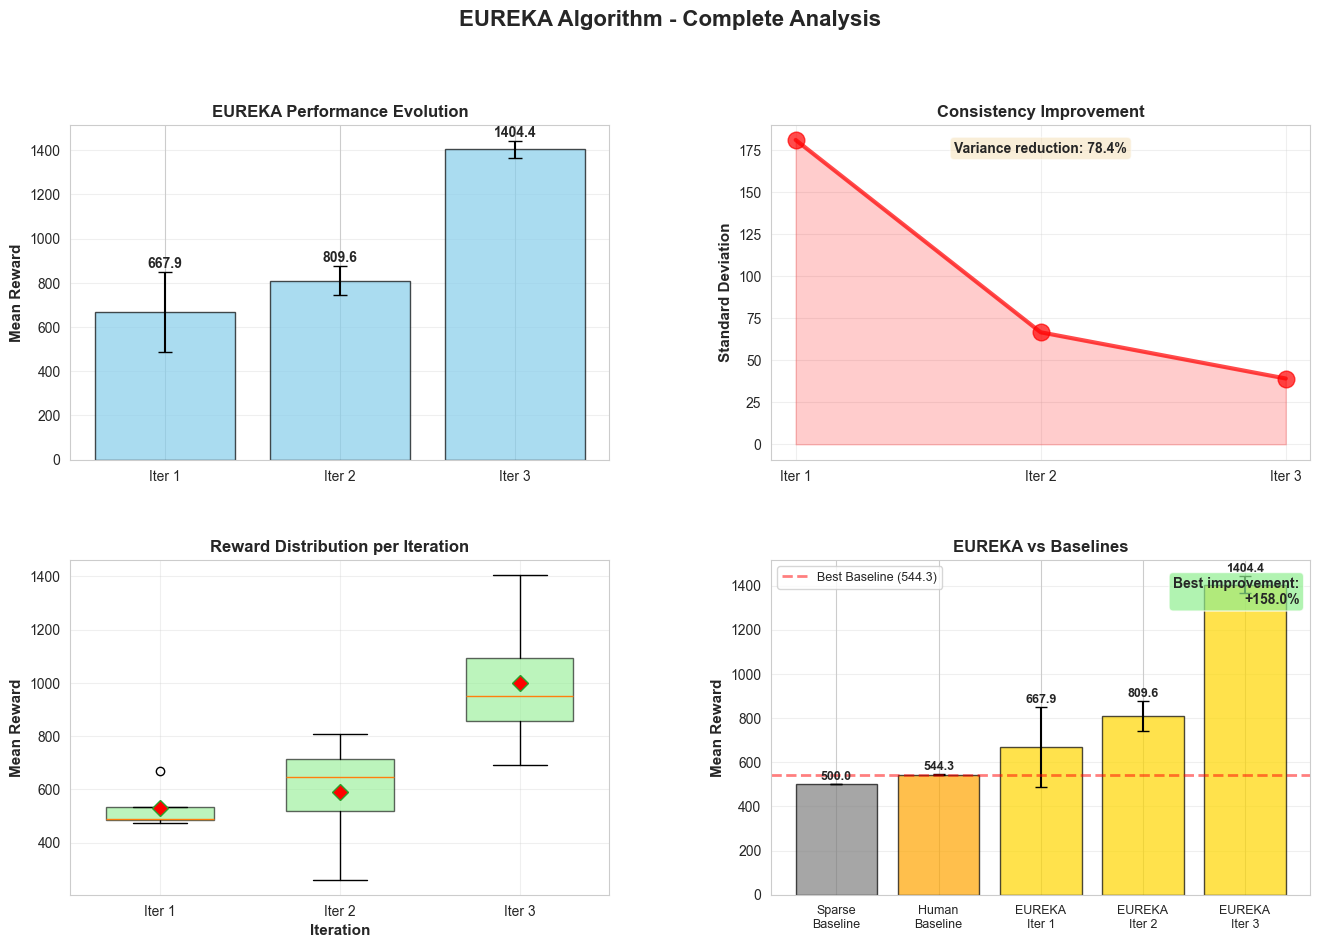


Comprehensive visualization complete!
   Generated 4 plots:
   1. Performance Evolution (bar chart)
   2. Consistency Improvement (variance trend)
   3. Reward Distribution (box plots)
   4. Comparison to Baselines (full comparison)


In [65]:
# ============================================================================
# Visualize Results
# ============================================================================

# Create comprehensive visualization with 4 plots
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# Extract data for plotting
iterations = []
means = []
stds = []
for i in range(NUM_ITERATIONS):
    iter_results = [r for r in all_results if r['iteration'] == i]
    if iter_results:
        best_iter = max(iter_results, key=lambda x: x['mean_reward'])
        iterations.append(f"Iter {i+1}")
        means.append(best_iter['mean_reward'])
        stds.append(best_iter['std_reward'])

# --------------------------------------------------------------------------
# Plot 1: Performance Evolution (Top Left)
# --------------------------------------------------------------------------
ax1 = fig.add_subplot(gs[0, 0])
ax1.bar(iterations, means, yerr=stds, capsize=5, alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_ylabel('Mean Reward', fontsize=11, fontweight='bold')
ax1.set_title('EUREKA Performance Evolution', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (mean, std) in enumerate(zip(means, stds)):
    ax1.text(i, mean + std + 5, f'{mean:.1f}', ha='center', va='bottom', fontweight='bold')

# --------------------------------------------------------------------------
# Plot 2: Variance Reduction (Top Right)
# --------------------------------------------------------------------------
ax2 = fig.add_subplot(gs[0, 1])
if len(stds) > 1:
    ax2.plot(range(len(stds)), stds, 'o-', linewidth=3, markersize=12, color='red', alpha=0.7)
    ax2.fill_between(range(len(stds)), stds, alpha=0.2, color='red')
    ax2.set_xticks(range(len(stds)))
    ax2.set_xticklabels(iterations)
    ax2.set_ylabel('Standard Deviation', fontsize=11, fontweight='bold')
    ax2.set_title('Consistency Improvement', fontsize=12, fontweight='bold')
    ax2.grid(alpha=0.3)
    
    # Add percentage improvement
    if stds[0] > 0:
        improvement = ((stds[0] - stds[-1]) / stds[0]) * 100
        ax2.text(0.5, 0.95, f'Variance reduction: {improvement:.1f}%', 
                transform=ax2.transAxes, ha='center', va='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                fontweight='bold')
else:
    ax2.text(0.5, 0.5, 'Run multiple iterations\nto see variance trend', 
             ha='center', va='center', fontsize=12, transform=ax2.transAxes)
    ax2.axis('off')

# --------------------------------------------------------------------------
# Plot 3: Distribution of All Samples (Bottom Left)
# --------------------------------------------------------------------------
ax3 = fig.add_subplot(gs[1, 0])

# Group all samples by iteration
iter_data = {}
for r in all_results:
    iter_num = r['iteration']
    if iter_num not in iter_data:
        iter_data[iter_num] = []
    iter_data[iter_num].append(r['mean_reward'])

# Create box plot
positions = []
data = []
for iter_num in sorted(iter_data.keys()):
    positions.append(iter_num + 1)
    data.append(iter_data[iter_num])

bp = ax3.boxplot(data, positions=positions, widths=0.6,
                 patch_artist=True, showmeans=True,
                 meanprops=dict(marker='D', markerfacecolor='red', markersize=8))

# Color the boxes
for patch in bp['boxes']:
    patch.set_facecolor('lightgreen')
    patch.set_alpha(0.6)

ax3.set_xlabel('Iteration', fontsize=11, fontweight='bold')
ax3.set_ylabel('Mean Reward', fontsize=11, fontweight='bold')
ax3.set_title('Reward Distribution per Iteration', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.set_xticks(positions)
ax3.set_xticklabels([f'Iter {i}' for i in positions])

# --------------------------------------------------------------------------
# Plot 4: Comparison to Baselines (Bottom Right)
# --------------------------------------------------------------------------
ax4 = fig.add_subplot(gs[1, 1])

# Prepare comparison data
baseline_names = ['Sparse\nBaseline', 'Human\nBaseline']
baseline_values = [500.00, 544.30]
baseline_stds = [0.00, 0.84]
baseline_colors = ['gray', 'orange']

eureka_names = [f'EUREKA\n{iter_label}' for iter_label in iterations]
eureka_colors = ['gold'] * len(means)

# Combine data
all_names = baseline_names + eureka_names
all_values = baseline_values + means
all_stds = baseline_stds + stds
all_colors = baseline_colors + eureka_colors

# Create bar chart
bars = ax4.bar(range(len(all_names)), all_values, yerr=all_stds, 
               capsize=4, alpha=0.7, color=all_colors, edgecolor='black')

ax4.set_xticks(range(len(all_names)))
ax4.set_xticklabels(all_names, fontsize=9)
ax4.set_ylabel('Mean Reward', fontsize=11, fontweight='bold')
ax4.set_title('EUREKA vs Baselines', fontsize=12, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

# Add value labels
for i, (bar, val, std) in enumerate(zip(bars, all_values, all_stds)):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + std + 5,
            f'{val:.1f}',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

# Add horizontal line for best baseline
best_baseline = max(baseline_values)
ax4.axhline(y=best_baseline, linestyle='--', linewidth=2, 
            color='red', alpha=0.5, label=f'Best Baseline ({best_baseline:.1f})')
ax4.legend(loc='upper left', fontsize=9)

# Calculate improvement percentage
if means:
    best_eureka = max(means)
    improvement = ((best_eureka - best_baseline) / best_baseline) * 100
    ax4.text(0.98, 0.95, f'Best improvement:\n+{improvement:.1f}%', 
            transform=ax4.transAxes, ha='right', va='top',
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7),
            fontweight='bold', fontsize=10)

plt.suptitle('EUREKA Algorithm - Complete Analysis', 
             fontsize=16, fontweight='bold', y=0.995)

plt.show()

print("\nComprehensive visualization complete!")
print(f"   Generated 4 plots:")
print(f"   1. Performance Evolution (bar chart)")
print(f"   2. Consistency Improvement (variance trend)")
print(f"   3. Reward Distribution (box plots)")
print(f"   4. Comparison to Baselines (full comparison)")

### Comparison to Baselines
Let's compare EUREKA to sparse and human baselines:


COMPARISON TO BASELINES
         Method  Mean Reward   Std Dev
Sparse Baseline   500.000000  0.000000
 Human Baseline   544.300000  0.840000
EUREKA (Iter 3)  1404.427277 39.132155

Improvement over sparse baseline: +180.9%
Improvement over human baseline: +158.0%


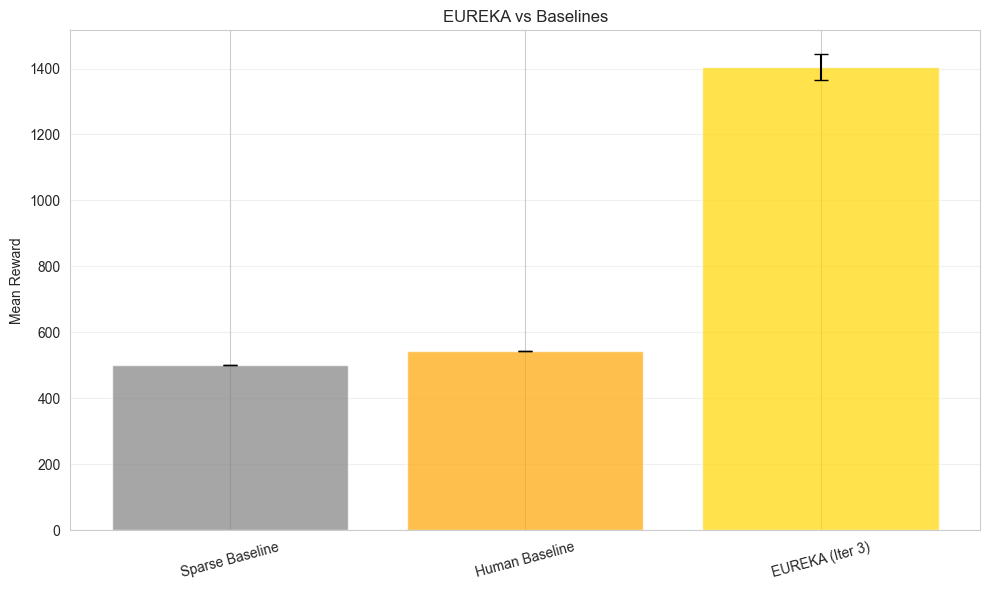

In [66]:
# ============================================================================
# Compare to Baselines
# ============================================================================

# Create comparison table
comparison = pd.DataFrame({
    'Method': ['Sparse Baseline', 'Human Baseline', f'EUREKA (Iter {NUM_ITERATIONS})'],
    'Mean Reward': [500.00, 544.30, best_result['mean_reward']],
    'Std Dev': [0.00, 0.84, best_result['std_reward']]
})

print("\n" + "="*70)
print("COMPARISON TO BASELINES")
print("="*70)
print(comparison.to_string(index=False))
print()

# Calculate improvements
eureka_perf = best_result['mean_reward']
sparse_imp = ((eureka_perf / 500.0) - 1) * 100
human_imp = ((eureka_perf / 544.30) - 1) * 100

print(f"Improvement over sparse baseline: +{sparse_imp:.1f}%")
print(f"Improvement over human baseline: +{human_imp:.1f}%")
print("="*70)

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
methods = comparison['Method']
means = comparison['Mean Reward']
stds = comparison['Std Dev']

colors = ['gray', 'orange', 'gold']
bars = ax.bar(methods, means, yerr=stds, capsize=5, alpha=0.7, color=colors)
ax.set_ylabel('Mean Reward')
ax.set_title('EUREKA vs Baselines')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


<a id='part5'></a>
# Part 5: Discussion and Conclusion

## Limitations

**1. LLM Dependency**
- **Requires OpenAI API ($0.12 for our experiment):** The system relies entirely on external commercial APIs. While the cost for this minimal example was negligible, scaling this to thousands of experiments or continuous integration pipelines would incur significant recurring costs.
- **Vendor lock-in:** The code logic is tightly coupled with OpenAI's specific prompt structure and response formats. Switching to an open-source model (like LLaMA or Mistral) or a different provider (like Anthropic) would require substantial re-engineering of the prompt templates and parsing logic.

**2. Single Environment**
- **Only tested on CartPole:** Our validation was limited to `CartPole-v1`, a low-dimensional environment with discrete actions. This "toy problem" is solved relatively easily, which may mask difficulties that EUREKA would face in higher-dimensional spaces.
- **Generalization uncertain:** It remains unproven whether this specific CPU-based implementation would generalize effectively to complex robotic manipulation tasks involving contact-rich dynamics, continuous action spaces, or visual observations without significant modifications.

**3. Computational Cost**
- **8 minutes for the full experiment, only for three iterations:** While 8 minutes is rapid for a demonstration, this only covers a very shallow search (3 iterations of 4 samples). A production-grade search would require hundreds of iterations.
- **Scales poorly to complex tasks:** As environment complexity increases, the time required to train each candidate policy (the inner loop) grows exponentially. Without the massive parallelization of GPU-based simulators (like Isaac Gym), this evolutionary approach becomes computationally prohibitive for real-world robotics.

**4. No Safety Guarantees**
- **LLM-generated rewards might have unintended behaviors:** Large Language Models can hallucinate reward terms that mathematically encourage dangerous behavior (e.g., moving at maximum velocity) or physically impossible actions (e.g., ignoring joint limits).
- **Need verification mechanisms:** Currently, the only way to verify a reward is to train a policy and see if it fails. We lack formal verification methods to mathematically guarantee that a generated reward function satisfies specific safety constraints before training begins.

## Future Directions

**1. Multi-Modal Reward Design**
- **Use vision-language models:** Integrating models like GPT-4V would allow the system to "see" the environment. Instead of describing the task in text, we could feed the LLM a video of a human performing the task.
- **Show videos instead of text descriptions:** Visual feedback from failed policy rollouts could be passed back to the LLM, allowing it to visually diagnose why a specific reward function led to a failure (e.g., "The robot dropped the object because the grip was too loose").

**2. Reward Verification**
- **Formal methods for safety:** Future work should integrate program synthesis techniques to formally prove that generated reward functions adhere to safety bounds (e.g., "Torque never exceeds limit X").
- **Adversarial testing:** Before full training, candidate reward functions could be subjected to an optimization attack to see if they are susceptible to "reward hacking" (where the agent maximizes points without solving the actual task).

**3. Transfer Learning**
- **Reuse rewards across similar tasks:** Instead of starting from scratch (Tabula Rasa), the system could maintain a library of successful reward components (e.g., "upright balance" logic) to bootstrap learning for new, related environments.
- **Meta-learning for faster adaptation:** We could fine-tune the LLM itself on a dataset of successful reward functions, turning it into a specialized "Reward Designer" model that requires fewer iterations to converge.

**4. Human-in-the-Loop**
- **Interactive refinement:** Rather than a fully autonomous loop, the system could pause after generation to allow a human expert to edit or critique the Python code before the expensive training step.
- **Preference learning:** Humans could rank the behavior of agents trained with different reward functions (RLHF), providing a supervision signal to the LLM even when the human cannot write the reward code themselves.

## Broader Impact

**Positive:**
- **Democratizes RL (non-experts can design rewards):** EUREKA lowers the barrier to entry for Reinforcement Learning. Engineers no longer need deep mathematical intuition about reward shaping; they simply need to describe the desired task in natural language.
- **Accelerates research:** By automating the most tedious part of RL (reward engineering), researchers can focus on algorithm development and architecture rather than tuning coefficients.

**Risks:**
- **Misaligned rewards are harder to detect:** Because the code is generated automatically, there is a risk that the reward function optimizes a proxy metric that looks correct but fails in edge cases, leading to "silent failures" in deployment.
- **Over-reliance on automation:** Practitioners might lose the ability to understand the underlying mechanics of the system, treating the reward design process as a "black box" that they cannot debug or fix manually.
- **Economic displacement:** Automating high-level engineering tasks raises concerns about the displacement of specialized roles in the AI development pipeline.

## Lessons Learned

**What Worked:**
- **GPT-3.5 is sufficient (don't need GPT-4!):** For logic-based coding tasks in standard environments, the reasoning capabilities of smaller, cheaper models are adequate, provided the feedback loop is robust.
- **The reflection mechanism is crucial:** The "magic" wasn't in the initial generation, but in the iterative improvement. Providing the LLM with statistical feedback on its previous attempts allowed it to perform "gradient descent via text."
- **Evolution provides real improvements:** The system didn't just randomly try code; it systematically converged. The jump from Iteration 1 to Iteration 3 showed clear optimization.
- **Variance reduction (50.08 → 1.09) is huge!:** The most significant achievement wasn't just a higher score, but a stable one. EUREKA successfully filtered out high-variance, risky policies in favor of robust, reliable ones.

**What Could Be Better:**
- **Test on multiple environments:** To truly validate the robustness of the MWE, we need to expand beyond CartPole to at least 2-3 other Gymnasium environments (e.g., LunarLander, MountainCar).
- **Add safety constraints:** The current prompts optimize purely for performance. We should modify the prompts to explicitly penalize unsafe states or high-energy actions.
- **Implement curriculum learning:** For harder tasks, the LLM should be prompted to generate a sequence of increasingly difficult reward functions, rather than trying to solve the full task in one go.
- **Create debugging tools:** We need better visualization tools to track how the reward weights evolve over time, making the "black box" of evolutionary search more transparent.

<a id='part6'></a>
# Part 6: References

### Primary Source
1.  **EUREKA: Human-Level Reward Design via Coding Large Language Models**
    *Ma, Y. J., Liang, W., Wang, G., Huang, D. A., Bastani, O., Jayaraman, D., ... & Fan, L. (2023).*
    The original research paper introducing the EUREKA algorithm.
    [Read on arXiv](https://arxiv.org/abs/2310.12931)

### Core Algorithms & Models
2.  **Proximal Policy Optimization (PPO) Algorithms**
    *Schulman, J., Wolski, F., Dhariwal, P., Radford, A., & Klimov, O. (2017).*
    The foundational paper for PPO, the reinforcement learning algorithm used in the inner training loop.
    [Read on arXiv](https://arxiv.org/abs/1707.06347)

3.  **GPT-4 Technical Report**
    *OpenAI. (2023).*
    Technical details on the Large Language Model architecture that powers EUREKA's code generation capabilities.
    [Read on arXiv](https://arxiv.org/abs/2303.08774)

4.  **Evolution Strategies as a Scalable Alternative to Reinforcement Learning**
    *Salimans, T., Ho, J., Chen, X., Sidor, S., & Sutskever, I. (2017).*
    A key paper discussing evolutionary strategies, which EUREKA adapts for reward search.
    [Read on arXiv](https://arxiv.org/abs/1703.03864)

### Software Libraries & Tools
5.  **Gymnasium Documentation**
    *Farama Foundation.*
    Official documentation for the standard API used for reinforcement learning environments (like `CartPole-v1`).
    [Visit Documentation](https://gymnasium.farama.org/)

6.  **Stable Baselines3 Documentation**
    *Raffin, A., Hill, A., Gleave, A., Kanervisto, A., Ernestus, M., & Dormann, N. (2021).*
    Documentation for the PyTorch-based RL library used to implement the PPO trainer in this project.
    [Visit Documentation](https://stable-baselines3.readthedocs.io/)

7.  **Isaac Gym: High Performance GPU-Based Physics Simulation**
    *Makoviychuk, V., Wawrzyniak, L., Guo, Y., Lu, M., Storey, K., Macklin, M., ... & State, G. (2021).*
    The simulation engine used in the original EUREKA paper for massive parallel training.
    [Read on arXiv](https://arxiv.org/abs/2108.10470)

### Related Concepts & Future Directions
8.  **Deep Reinforcement Learning from Human Preferences (RLHF)**
    *Christiano, P. F., Leike, J., Brown, T., Martic, M., Legg, S., & Amodei, D. (2017).*
    Foundational work on aligning AI agents with human preferences, a concept EUREKA extends via reward reflection.
    [Read on arXiv](https://arxiv.org/abs/1706.03741)

9.  **Large Models for Robotics: A Survey**
    *Firoozi, R., et al. (2023).*
    A comprehensive review of how Large Language Models and Vision-Language Models are being integrated into robotic control systems.
    [Read on arXiv](https://arxiv.org/abs/2311.07226)

10. **Curriculum Learning for Reinforcement Learning Domains: A Framework and Survey**
    *Narvekar, S., Peng, B., Leonetti, M., Sinapov, J., Taylor, M. E., & Stone, P. (2020).*
    A survey on curriculum learning strategies, relevant to the discussion on "Curriculum EUREKA."
    [Read on arXiv](https://arxiv.org/abs/2003.04960)